In [1]:
#调整图像的transform后测试集相关系数提高
#装载GoogleDrive云端网盘
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/coreing_rop')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pdb
import numpy as np
import torch, os, random
from torch.utils import data
from torchvision import transforms
from PIL import Image
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import pdb
import numpy as np
import pandas as pd
import torch, os, random
from torch.utils import data
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score,mean_squared_error #直接调用库函数进行输出R2
import torch.backends.cudnn as cudnn
cudnn.benchmark = False

In [3]:
train=pd.read_csv('./train_24.csv')
test=pd.read_csv('./test_6.csv')
train_all=pd.concat([train,test])
imagepath=train_all.filter(['ImagePath'])
imagepath_train=imagepath[0:24]
imagepath_test=imagepath[24:30]
from sklearn.preprocessing import MinMaxScaler,StandardScaler
ms = MinMaxScaler()
# min_max_scaler=StandardScaler()
train_all_y = train_all.filter(['ROP'])   
train_all_x = train_all.filter(['Depth', 'RPM', 'WOB'])
feat_names=train_all_y.columns
train_all_y=ms.fit_transform(train_all_y)
train_all_y=pd.DataFrame(columns=feat_names,data=train_all_y)
feat_names=train_all_x.columns
train_all_x=ms.fit_transform(train_all_x)
train_all_x=pd.DataFrame(columns=feat_names,data=train_all_x)
train_all_x['Dillability_1']=0.5
train_all_x['Dillability_2']=0.5
train_all_x['Dillability_3']=0.5
train_all_x['Dillability_4']=0.5
train_all_x['Dillability_5']=0.5
train_all_x['Dillability_6']=0.5
train_x=train_all_x[0:24]
train_y=train_all_y[0:24]
test_x=train_all_x[24:30]
test_y=train_all_y[24:30]
#读取数据
class Csv(data.Dataset):
    def __init__(self, train_x,train_y, transform=None, size=(120, 120)):
        self.transform = transform
        self.size = size
        self.train_x = train_x
        self.train_y = train_y
    def __getitem__(self, index):         
        x_tensor=torch.FloatTensor(self.train_x[index])
        y_tensor=torch.FloatTensor(self.train_y[index])
        return  x_tensor, y_tensor
    def __len__(self):
        return len(self.train_x)
trian_dset = Csv(train_x.values,train_y.values)
test_dset = Csv(test_x.values,test_y.values)
train_loader = DataLoader(trian_dset,batch_size=1, num_workers=0)
valid_loader = DataLoader(test_dset, batch_size=1, num_workers=0)
#单独钻参
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        
        self.mlp = nn.Sequential(
        torch.nn.Linear(9, 32),
        torch.nn.ReLU(),
        torch.nn.Linear(32, 1),
        )       
    def forward(self, parameters):        
        out = self.mlp(parameters)        
        return out
learning_rate = 0.1
#model
model = net()

if torch.cuda.is_available():
    print('gpu')
    model = model.cuda()

# 定义损失函数和优化器
criterion = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)
optimizer=optim.Adadelta(model.parameters(), lr=learning_rate, rho=0.9, eps=1e-06, weight_decay=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)
MES_best=10
# 训练模型
#Train
epoch = 10000
for epoch_i in range(0,epoch):    
  model.train()
  train_loss=0
  y_train_predict=[]
  y_train_ture=[]
  for data_ in train_loader:
    parameters, label = data_
    if torch.cuda.is_available():
      parameters= parameters.cuda()
      label = label.cuda()
    else:
      parameters= Variable(parameters)
      label = Variable(label)
    out = model(parameters)
    loss = criterion(out, label)
    print_loss = loss.data.item()
    train_loss += loss.data.item()*label.size(0)
    y_train_predict.extend(out.cpu().detach().numpy())
    y_train_ture.extend(label.cpu().detach().numpy())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  if (epoch_i+1)%100 == 0:
    # print('epoch: {}, Train MSE Loss: {:.6f}, R2: {:.6f}'.format(epoch_i, train_loss/(len(train_x)), 
    # r2_score(y_train_predict,y_train_ture)))
    print('epoch: {}, Train MSE Loss: {:.6f}'.format(epoch_i, train_loss/(len(train_x)), 
    ))

#     模型评估
    model.eval()
    eval_loss = 0
    y_predict=[]
    y_ture=[]
    for data_ in valid_loader:
      parameters, label = data_
      if torch.cuda.is_available():
        parameters= parameters.cuda()
        label = label.cuda()
      out = model(parameters)
      loss = criterion(out, label)
      eval_loss += loss.data.item()*label.size(0)
      y_predict.extend(out.cpu().detach().numpy())
      y_ture.extend(label.cpu().detach().numpy())

    y_ture=np.array(y_ture)
    y_predict=np.array(y_predict)
    print('Test MSE Loss: {:.6f}, R2: {:.6f}'.format(
      eval_loss / (len(test_x)),
      r2_score(y_ture,y_predict)))
    MES_test=eval_loss / (len(test_x))
    
    if MES_best>MES_test:
      MES_best=MES_test
      torch.save(model.state_dict(), 'best_net_model_state_dict.pth')
      print('----------')
      s=0
    else:
      s+=1
      if s>20:
        break

epoch: 99, Train MSE Loss: 0.060248
Test MSE Loss: 0.077125, R2: 0.038254
----------
epoch: 199, Train MSE Loss: 0.058134
Test MSE Loss: 0.073405, R2: 0.084641
----------
epoch: 299, Train MSE Loss: 0.056648
Test MSE Loss: 0.070632, R2: 0.119218
----------
epoch: 399, Train MSE Loss: 0.055569
Test MSE Loss: 0.068412, R2: 0.146909
----------
epoch: 499, Train MSE Loss: 0.054853
Test MSE Loss: 0.066808, R2: 0.166913
----------
epoch: 599, Train MSE Loss: 0.054336
Test MSE Loss: 0.065605, R2: 0.181903
----------
epoch: 699, Train MSE Loss: 0.053992
Test MSE Loss: 0.064725, R2: 0.192882
----------
epoch: 799, Train MSE Loss: 0.053730
Test MSE Loss: 0.064093, R2: 0.200766
----------
epoch: 899, Train MSE Loss: 0.053545
Test MSE Loss: 0.063626, R2: 0.206585
----------
epoch: 999, Train MSE Loss: 0.053428
Test MSE Loss: 0.063275, R2: 0.210960
----------
epoch: 1099, Train MSE Loss: 0.053332
Test MSE Loss: 0.063027, R2: 0.214050
----------
epoch: 1199, Train MSE Loss: 0.053119
Test MSE Loss: 0

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


0.4976065634477962
0.45212369353177007


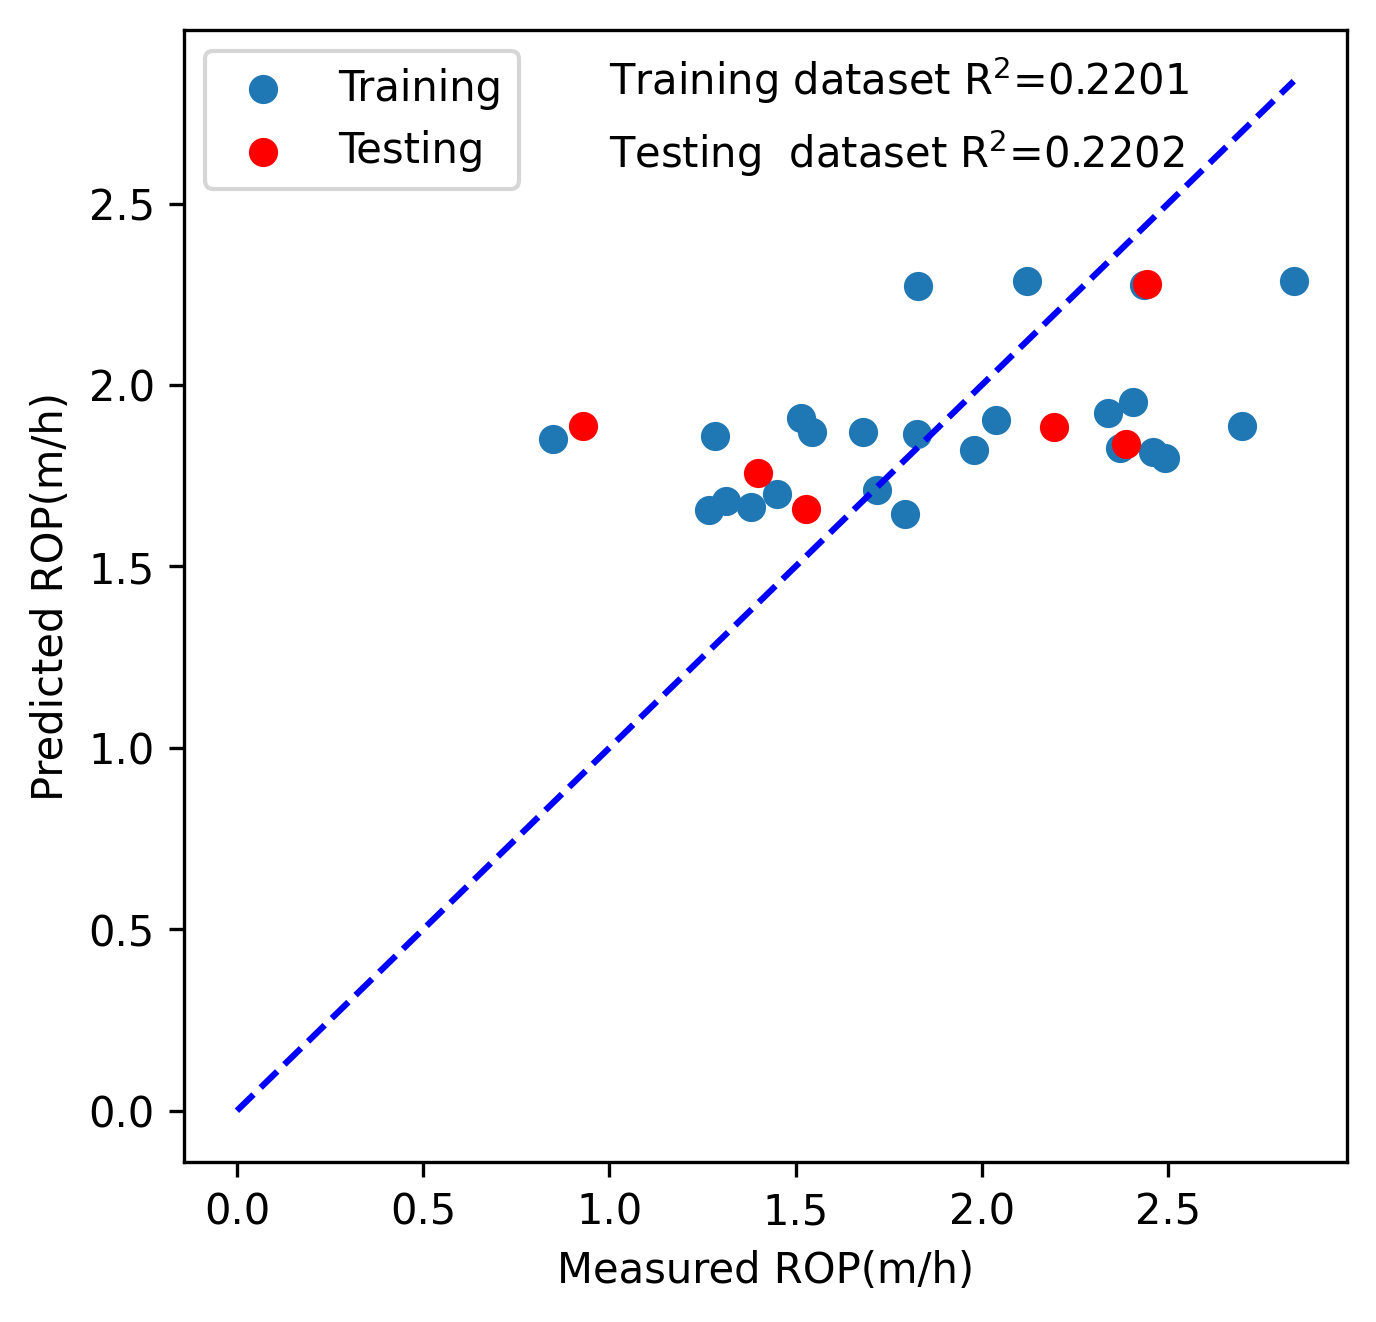

In [4]:
model = net()
model.load_state_dict(torch.load('best_net_model_state_dict.pth'))
model.eval()
y_train_predict=[]
y_train_ture=[]
for data_ in train_loader:
  parameters, label = data_
  # img = img.view(img.size(0), -1)
  # img = Variable(img)
  if torch.cuda.is_available():
    # img = img.cuda()
    parameters= parameters.cuda()
    label = label.cuda()
  else:
    # img = Variable(img)
    parameters= Variable(parameters)
    label = Variable(label)
  out = model(parameters)
  y_train_predict.extend(out.cpu().detach().numpy())
  y_train_ture.extend(label.cpu().detach().numpy())
y_train_ture=np.array(y_train_ture)
y_train_predict=np.array(y_train_predict)
y_test_predict=[]
y_test_ture=[]
for data_ in valid_loader:
  parameters, label = data_
  if torch.cuda.is_available():
    parameters= parameters.cuda()
    label = label.cuda()
  out = model(parameters)
  y_test_predict.extend(out.cpu().detach().numpy())
  y_test_ture.extend(label.cpu().detach().numpy())
y_test_ture=np.array(y_test_ture)
y_test_predict=np.array(y_test_predict)
y_minmax=MinMaxScaler().fit(train_all['ROP'].values.reshape(-1,1))
y_test_predict=y_minmax.inverse_transform(y_test_predict.reshape(1,-1))
y_train_predict=y_minmax.inverse_transform(y_train_predict.reshape(1,-1))
train_all_y = train_all.filter(['ROP'])
test_y=train_all_y[24:30]
train_y=train_all_y[0:24]
y_train=np.array(train_y)
y_test=np.array(test_y)

y_test_max=train_all_y.max()

fig2=plt.figure(figsize=(5,5),dpi=300)
plt.scatter(y_train,y_train_predict,label='Training')
plt.scatter(y_test,y_test_predict,label='Testing',color='red')

plt.plot( (0,y_test_max), (0,y_test_max),color = 'blue',  linestyle="--" )
plt.xlabel('Measured ROP(m/h)')
plt.ylabel('Predicted ROP(m/h)')

plt.text(1.0,2.6,'Testing  dataset R$^2$=%.4f'%r2_score(y_test.reshape(-1), y_test_predict.reshape(-1)))
plt.text(1.0,2.8,'Training dataset R$^2$=%.4f'%r2_score(y_train.reshape(-1), y_train_predict.reshape(-1)))
plt.legend()
plt.savefig('net.png', dpi=300,bbox_inches='tight')
print(mean_squared_error(y_test.reshape(-1), y_test_predict.reshape(-1))**0.5)
print(mean_squared_error(y_train.reshape(-1), y_train_predict.reshape(-1))**0.5)

In [5]:
#读取图片和数据
class CsvImage(data.Dataset):
    def __init__(self, imagepath,train_x,train_y, transform=None, size=(120, 120)):
        self.transform = transform
        self.size = size
        self.imgpath = imagepath
        self.train_x = train_x
        self.train_y = train_y
    def __getitem__(self, index):
        imgPath = self.imgpath[index]
        img = Image.open(imgPath).convert('RGB') 

        if self.transform is not None:
            img = self.transform(img)

        x_tensor=torch.FloatTensor(self.train_x[index])
        y_tensor=torch.FloatTensor(self.train_y[index])

        return img , x_tensor, y_tensor

    def __len__(self):
        return len(self.imgpath)

In [6]:
#选取同一种钻头的
train=pd.read_csv('./train_24.csv')
test=pd.read_csv('./test_6.csv')
train_all=pd.concat([train,test])

imagepath=train_all.filter(['ImagePath'])
imagepath_train=imagepath[0:24]
imagepath_test=imagepath[24:30]
from sklearn.preprocessing import MinMaxScaler,StandardScaler
ms = MinMaxScaler()
# min_max_scaler=StandardScaler()
train_all_y = train_all.filter(['ROP'])   
train_all_x = train_all.filter(['Depth', 'RPM', 'WOB'])
feat_names=train_all_y.columns
train_all_y=ms.fit_transform(train_all_y)

train_all_y=pd.DataFrame(columns=feat_names,data=train_all_y)

feat_names=train_all_x.columns
train_all_x=ms.fit_transform(train_all_x)
train_all_x=pd.DataFrame(columns=feat_names,data=train_all_x)
train_x=train_all_x[0:24]
train_y=train_all_y[0:24]
test_x=train_all_x[24:30]
test_y=train_all_y[24:30]

In [7]:
transform =transforms.Compose([
        transforms.Resize((32, 256)),#height width
        transforms.CenterCrop((30,250)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

trian_dset = CsvImage(imagepath_train.values.flatten().tolist(),train_x.values,train_y.values, transform)
test_dset = CsvImage(imagepath_test.values.flatten().tolist(),test_x.values,test_y.values, transform)
train_loader = DataLoader(trian_dset,batch_size=1, num_workers=0)
valid_loader = DataLoader(test_dset, batch_size=1, num_workers=0)

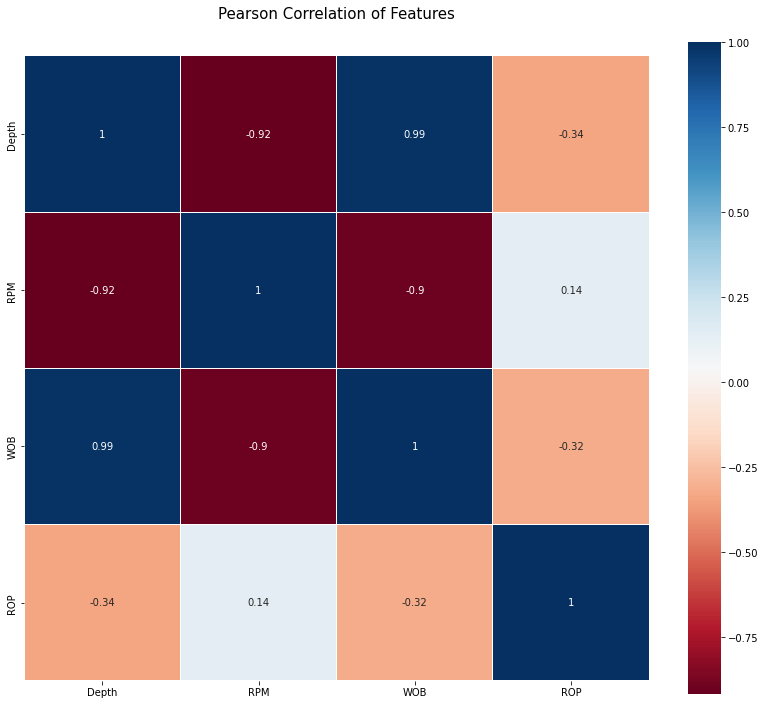

In [8]:
import seaborn as sns
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_all.filter(['Depth', 'RPM', 'WOB','ROP']).astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.savefig('Pearson.png', dpi=300,bbox_inches='tight')

In [9]:
from torch import nn
#冻结BN
def fix_bn(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm') != -1:
        m.eval()
class Twoinput(nn.Module):
    def __init__(self):
        super(Twoinput, self).__init__()
        self.model = models.resnet50(pretrained=True)
        # self.model = models.resnet50(pretrained = False)
        # self.model=torch.load('resnet50-0676ba61.pth')
        # self.model = models.resnet101(pretrained=True)
        # self.model = models.resnet152(pretrained=True)
        # self.model = models.resnet18(pretrained=True)
        # self.model = models.wide_resnet50_2(pretrained=True)
        # for param in self.model.parameters():
        #   param.requires_grad = False
        # self.model = models.wide_resnet101_2(pretrained=True)
        num_ftrs = self.model.fc.in_features
        # self.model.fc = nn.Linear(num_ftrs,8)
        self.model.fc = nn.Sequential(
        torch.nn.Linear(num_ftrs, 256),
        # torch.nn.Linear(num_ftrs, 6),
        # torch.nn.Dropout(0.5),
        torch.nn.ReLU(),
        # torch.nn.Linear(512, 256),
        # torch.nn.Dropout(0.5),
        # torch.nn.ReLU(),
        # torch.nn.Sigmoid(),
        torch.nn.Linear(256, 6)
        # torch.nn.Linear(128, 6),
        )
        self.mlp = net()
        self.mlp.load_state_dict(torch.load('best_net_model_state_dict.pth'))
        # self.mlp = nn.Sequential(
        # torch.nn.Linear(9,32),
        # torch.nn.ReLU(),
        # torch.nn.Linear(32, 1),
        # ) 
        # self.mlp = nn.Sequential(
        # torch.nn.Linear(9,32),
        # torch.nn.ReLU(),
        # torch.nn.Linear(32, 1),
        # ) 
    def forward(self, image,parameters):
        image = self.model(image)

        # combined = torch.cat((image.view(image.size(0), -1),
        #                   parameters.view(parameters.size(0), -1)), dim=1)
        combined = torch.cat((parameters.view(parameters.size(0), -1),
                    image.view(image.size(0), -1)
                          ), dim=1)
        out = self.mlp(combined)
        
        return out

In [10]:
from torch.optim import lr_scheduler
learning_rate = 0.001
# 选择模型
model = Twoinput()
if torch.cuda.is_available():
    print('gpu')
    model = model.cuda()
# 定义损失函数和优化器
criterion = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
optimizer=optim.Adadelta(model.parameters(), lr=learning_rate, rho=0.9, eps=1e-06, weight_decay=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
MES_best=10
# 训练模型
epoch = 300
# epoch = 60
for epoch_i in range(0,epoch):    
  model.train()
  model.apply(fix_bn)
  train_loss=0
  y_train_predict=[]
  y_train_ture=[]
  for data_ in train_loader:
    img,parameters, label = data_
    img = Variable(img)
    if torch.cuda.is_available():
      img = img.cuda()
      parameters= parameters.cuda()
      label = label.cuda()
    else:
      img = Variable(img)
      parameters= Variable(parameters)
      label = Variable(label)
    out = model(img,parameters)
    loss = criterion(out, label)
    print_loss = loss.data.item()
    train_loss += loss.data.item()*label.size(0)
    y_train_predict.extend(out.cpu().detach().numpy())
    y_train_ture.extend(label.cpu().detach().numpy())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  if (epoch_i+1)%1 == 0:
    print('epoch: {}, Train MSE Loss: {:.6f}'.format(epoch_i, train_loss/(len(train_x)), 
    ))
#     模型评估
    model.eval()
    eval_loss = 0
    y_predict=[]
    y_ture=[]
    for data_ in valid_loader:
      img,parameters, label = data_
#             img.show()
      # img = img.view(img.size(0), -1)
      img = Variable(img)
      if torch.cuda.is_available():
        img = img.cuda()
        parameters= parameters.cuda()
        label = label.cuda()

      out = model(img,parameters)
      loss = criterion(out, label)
      eval_loss += loss.data.item()*label.size(0)
      y_predict.extend(out.cpu().detach().numpy())
      y_ture.extend(label.cpu().detach().numpy())
    y_ture=np.array(y_ture)
    y_predict=np.array(y_predict)
    MES_test=eval_loss / (len(test_x))
    print('Test MSE Loss: {:.6f}, R2: {:.6f}'.format(MES_test
      ,
      r2_score(y_ture,y_predict)))
    if MES_best>MES_test:
      MES_best=MES_test
      torch.save(model.state_dict(), 'best_model_state_dict.pth')
      print('----------')
      s=0
    else:
      s+=1
      if s>20:
        break

epoch: 0, Train MSE Loss: 0.194023
Test MSE Loss: 0.065073, R2: 0.188542
----------
epoch: 1, Train MSE Loss: 0.058835
Test MSE Loss: 0.018460, R2: 0.769809
----------
epoch: 2, Train MSE Loss: 0.034822
Test MSE Loss: 0.013123, R2: 0.836359
----------
epoch: 3, Train MSE Loss: 0.025049
Test MSE Loss: 0.011424, R2: 0.857544
----------
epoch: 4, Train MSE Loss: 0.018514
Test MSE Loss: 0.010642, R2: 0.867289
----------
epoch: 5, Train MSE Loss: 0.013798
Test MSE Loss: 0.010378, R2: 0.870582
----------
epoch: 6, Train MSE Loss: 0.010137
Test MSE Loss: 0.010419, R2: 0.870078
epoch: 7, Train MSE Loss: 0.007402
Test MSE Loss: 0.010585, R2: 0.868005
epoch: 8, Train MSE Loss: 0.005402
Test MSE Loss: 0.010822, R2: 0.865052
epoch: 9, Train MSE Loss: 0.004005
Test MSE Loss: 0.010922, R2: 0.863809
epoch: 10, Train MSE Loss: 0.002948
Test MSE Loss: 0.010997, R2: 0.862863
epoch: 11, Train MSE Loss: 0.002162
Test MSE Loss: 0.011023, R2: 0.862538
epoch: 12, Train MSE Loss: 0.001583
Test MSE Loss: 0.011

In [11]:
model = Twoinput()
model.load_state_dict(torch.load('best_model_state_dict.pth'))
model.eval()
y_train_predict=[]
y_train_ture=[]
for data_ in train_loader:
  img,parameters, label = data_
  # img = img.view(img.size(0), -1)
  img = Variable(img)
  if torch.cuda.is_available():
    img = img.cuda()
    parameters= parameters.cuda()
    label = label.cuda()
  else:
    img = Variable(img)
    parameters= Variable(parameters)
    label = Variable(label)
  out = model(img,parameters)
  # loss = criterion(out, label)
  # print_loss = loss.data.item()#张量转换为浮点数
  # train_loss += loss.data.item()*label.size(0)
  y_train_predict.extend(out.cpu().detach().numpy())
  y_train_ture.extend(label.cpu().detach().numpy())
y_train_ture=np.array(y_train_ture)
y_train_predict=np.array(y_train_predict)
y_test_predict=[]
y_test_ture=[]
for data_ in valid_loader:
  img,parameters, label = data_
#             img.show()
  # img = img.view(img.size(0), -1)
  img = Variable(img)
  if torch.cuda.is_available():
    img = img.cuda()
    parameters= parameters.cuda()
    label = label.cuda()

  out = model(img,parameters)
  # loss = criterion(out, label)
  # eval_loss += loss.data.item()*label.size(0)
  y_test_predict.extend(out.cpu().detach().numpy())
  y_test_ture.extend(label.cpu().detach().numpy())
y_test_ture=np.array(y_test_ture)
y_test_predict=np.array(y_test_predict)

In [12]:
r2_score(y_train_ture, y_train_predict)

0.999408914400449

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


0.16863110643691803
0.012447023213068543


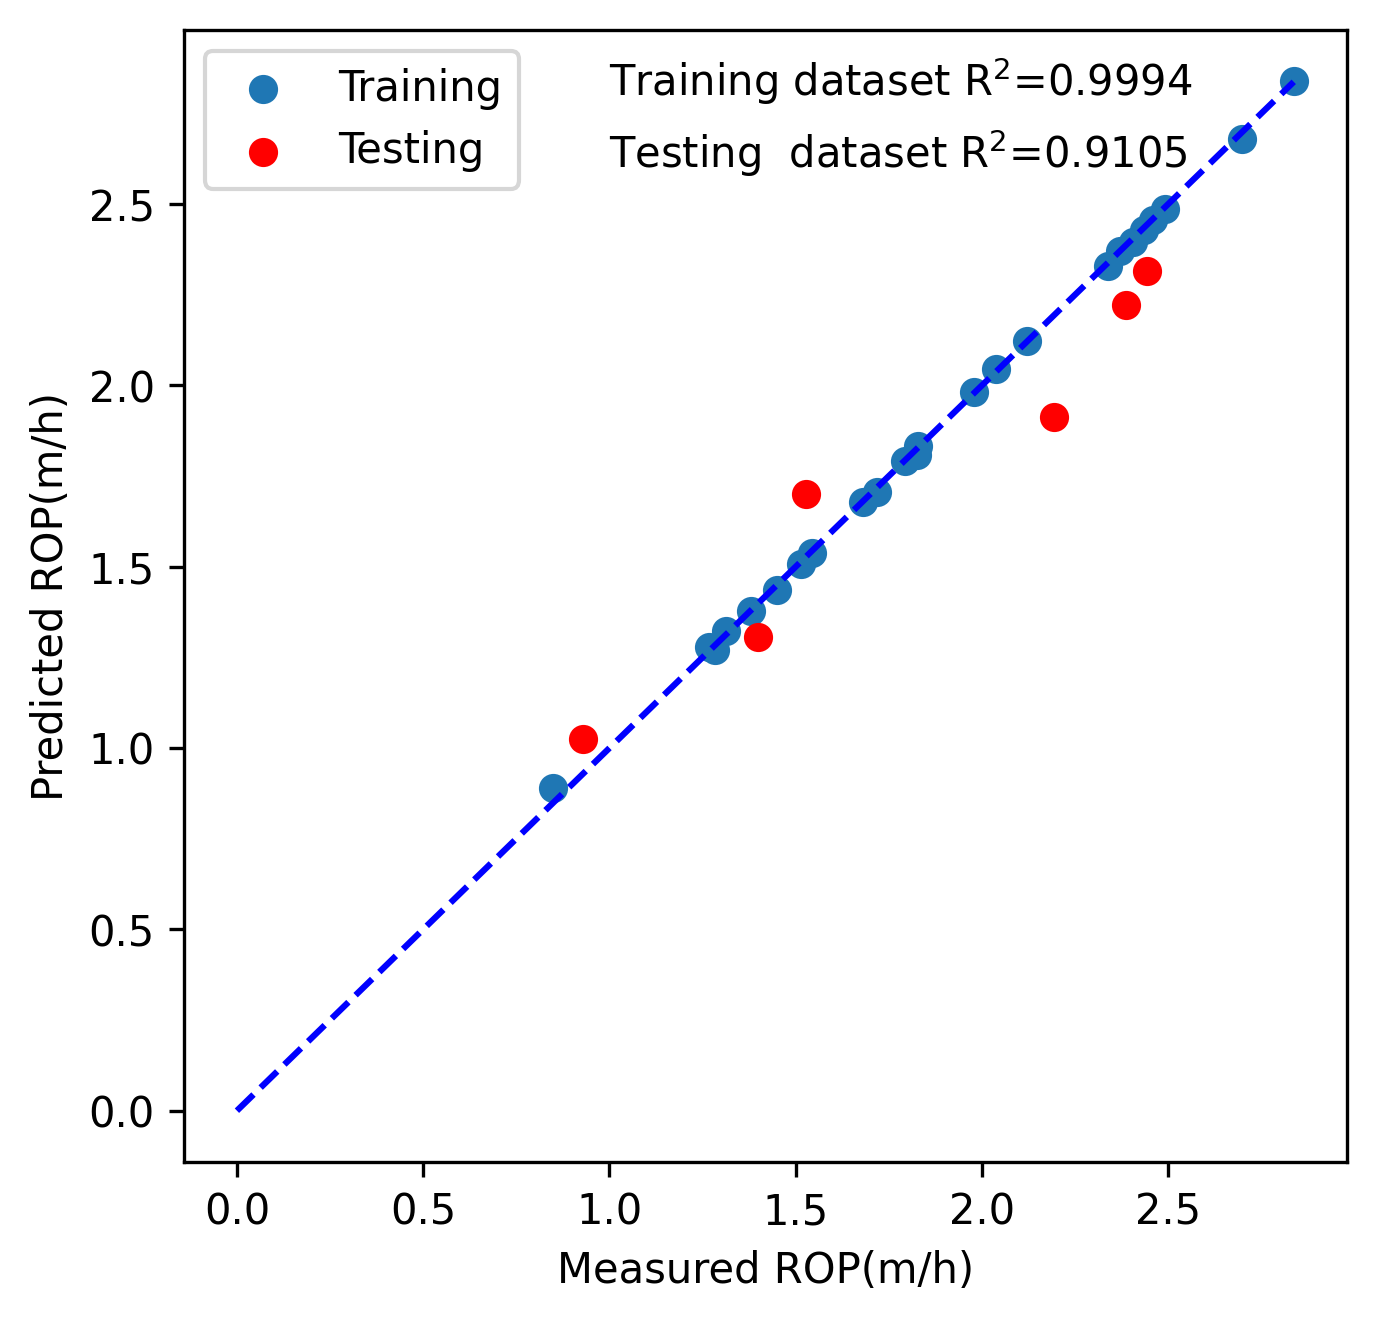

In [13]:
y_minmax=MinMaxScaler().fit(train_all['ROP'].values.reshape(-1,1))
y_test_predict=y_minmax.inverse_transform(y_test_predict.reshape(1,-1))
y_train_predict=y_minmax.inverse_transform(y_train_predict.reshape(1,-1))
train_all_y = train_all.filter(['ROP'])
test_y=train_all_y[24:30]
train_y=train_all_y[0:24]
y_train=np.array(train_y)
y_test=np.array(test_y)
# y_minmax=MinMaxScaler().fit(train_2['ROP'].values.reshape(-1,1))
# y_test_i=y_minmax.inverse_transform(y_test.values.reshape(-1,1))
# y_train_i=y_minmax.inverse_transform(y_train.values.reshape(-1,1))
y_test_max=train_all_y.max()
# y_test_pred_s_i=y_minmax.inverse_transform(y_test_pred_s.reshape(-1,1))
# y_train_pred_s_i=y_minmax.inverse_transform(y_train_pred_s.reshape(-1,1))
fig2=plt.figure(figsize=(5,5),dpi=300)
plt.scatter(y_train,y_train_predict,label='Training')
plt.scatter(y_test,y_test_predict,label='Testing',color='red')

plt.plot( (0,y_test_max), (0,y_test_max),color = 'blue',  linestyle="--" )
plt.xlabel('Measured ROP(m/h)')
plt.ylabel('Predicted ROP(m/h)')
# plt.text(13.0,20,'R$^2$=%.4f'%r2_score(y_test, y_test_pred_s))
# plt.text(13.0,19,'RMSE=%.4f'%mean_squared_error(y_test_i, y_test_pred_s_i)**0.5)

# plt.text(10,20,'Training R$^2$=%.4f'%r2_score(y_train, y_train_pred_s))
# plt.text(10,19,'Training RMSE=%.4f'%mean_squared_error(y_train_i, y_train_pred_s_i)**0.5)
plt.text(1.0,2.6,'Testing  dataset R$^2$=%.4f'%r2_score(y_test.reshape(-1), y_test_predict.reshape(-1)))
plt.text(1.0,2.8,'Training dataset R$^2$=%.4f'%r2_score(y_train.reshape(-1), y_train_predict.reshape(-1)))
plt.legend()
plt.savefig('Twoinput.png', dpi=300,bbox_inches='tight')
print(mean_squared_error(y_test.reshape(-1), y_test_predict.reshape(-1))**0.5)
print(mean_squared_error(y_train.reshape(-1), y_train_predict.reshape(-1))**0.5)

In [14]:
# 2. PSO优化算法
class PSO(object):
    def __init__(self,particle_num,particle_dim,iter_num,
                 c1,c2,w,max_value,min_value,train_X_initial,img,
                 trainy_initial,model):
        '''参数初始化
        particle_num(int):粒子群的粒子数量
        particle_dim(int):粒子维度，对应待寻优参数的个数
        iter_num(int):最大迭代次数
        c1(float):局部学习因子，表示粒子移动到该粒子历史最优位置(pbest)的加速项的权重
        c2(float):全局学习因子，表示粒子移动到所有粒子最优位置(gbest)的加速项的权重
        w(float):惯性因子，表示粒子之前运动方向在本次方向上的惯性
        max_value(float):参数的最大值
        min_value(float):参数的最小值
        '''
        self.particle_num = particle_num
        self.particle_dim = particle_dim
        self.iter_num = iter_num
        self.c1 = c1  ##通常设为2.0
        self.c2 = c2  ##通常设为2.0
        self.w = w    
        self.max_value = max_value
        self.min_value = min_value
        self.trainX_initial=train_X_initial.copy(deep=True)
        self.model=model
        self.img=img
        self.trainy_initial=trainy_initial.copy(deep=True)        
    def RPM_select(self,rpm_pso):
      #寻找最相近的RPM 
      select = 0
      for i in range(len(RPM)):        
        if (abs(RPM[i]-rpm_pso) < abs(select-rpm_pso)):          
          select = RPM[i]        
        # select = min(select, abs(select2))
      # print(select)
        
      return select

            
### 2.1 粒子群初始化
    def swarm_origin(self):
        '''粒子群初始化
        input:self(object):PSO类
        output:particle_loc(list):粒子群位置列表
               particle_dir(list):粒子群方向列表
        '''
        particle_loc = []
        particle_dir = []
        for i in range(self.particle_num):
          tmp1 = []
          tmp2 = []
          for j in range(self.particle_dim):
            a = random.random()
            b = random.random()
            tmp1.append(a * (self.max_value - self.min_value) + self.min_value)
            tmp2.append(b)
          # print('tmp1',tmp1)
          # rpm_pso=tmp1[0]
          # tmp1[0]=self.RPM_select(rpm_pso)
          particle_loc.append(tmp1)
          particle_dir.append(tmp2)
            
        #把第一个粒子设置为初始值
        trainX_pso=self.trainX_initial.values.reshape(1, -1)
        particle_loc[0][0]=trainX_pso[0][1]#RPM
        # particle_loc[0][1]=trainX_pso[0][2]
        particle_loc[0][1]=trainX_pso[0][2]#WOB 
        # particle_loc[0][2]=trainX_pso[0][3]#Q
        # particle_loc[0][3]=trainX_pso[0][3]        
        return particle_loc,particle_dir

## 2.2 计算适应度函数数值列表;初始化pbest_parameters和gbest_parameter   
    def fitness(self,particle_loc):
        '''计算适应度函数值
        input:self(object):PSO类
              particle_loc(list):粒子群位置列表
        output:fitness_value(list):适应度函数值列表
        '''
        fitness_value = []
        ### 1.预测值
        # for i in range(self.particle_num):
        #     rbf_svm = svm.SVC(kernel = 'rbf', C = particle_loc[i][0], gamma = particle_loc[i][1])
        #     cv_scores = cross_validation.cross_val_score(rbf_svm,trainX,trainY,cv =3,scoring = 'accuracy')
        #     fitness_value.append(cv_scores.mean())
        for i in range(self.particle_num):
          trainX_pso=self.trainX_initial.values.reshape(1,-1)
          # print(trainX_pso)
          trainX_pso[0][1]=particle_loc[i][0]#RPM
          # trainX_pso[0][2]=particle_loc[i][1]
          trainX_pso[0][2]=particle_loc[i][1]#WOB
          # trainX_pso[0][3]=particle_loc[i][2]
          # print(self.img)
          # print(i)
          # print('trainX_pso',trainX_pso)
          # print(trainy_initial)

          dset_pso = CsvImage(self.img.values.flatten().tolist(),trainX_pso,
                              self.trainy_initial.values.reshape(1,-1), transform)
          pso_loader = DataLoader(dset_pso, num_workers=0)
          for pso_i in pso_loader:
            img_pso,parameters_pso, label_pso = pso_i   
            if torch.cuda.is_available():
              img_pso = img_pso.cuda()
              parameters_pso= parameters_pso.cuda()
              label_pso = label_pso.cuda()
            else:
              img_pso = Variable(img_pso)
              parameters_pso= Variable(parameters_pso)
              label_pso = Variable(label_pso)
            y_pred_pso = self.model(img_pso,parameters_pso)
            # print('label_pso,y_pred_pso',label_pso,y_pred_pso) 
            # y_pred_pso=stacked.predict(trainX_pso)#预测
          fitness_value.append(y_pred_pso)

        ### 2. 当前粒子群最优适应度函数值和对应的参数
        current_fitness = 0.0
        current_parameter = []
        for i in range(self.particle_num):
            if current_fitness < fitness_value[i]:
                current_fitness = fitness_value[i]
                current_parameter = particle_loc[i]
        return fitness_value,current_fitness,current_parameter 
        

## 2.3  粒子位置更新 
    def updata(self,particle_loc,particle_dir,gbest_parameter,pbest_parameters):
        '''粒子群位置更新
        input:self(object):PSO类
              particle_loc(list):粒子群位置列表
              particle_dir(list):粒子群方向列表
              gbest_parameter(list):全局最优参数
              pbest_parameters(list):每个粒子的历史最优值
        output:particle_loc(list):新的粒子群位置列表
               particle_dir(list):新的粒子群方向列表
        '''
        ## 1.计算新的量子群方向和粒子群位置
        for i in range(self.particle_num): 
            a1 = [x * self.w for x in particle_dir[i]]
            a2 = [y * self.c1 * random.random() for y in list(np.array(pbest_parameters[i]) - np.array(particle_loc[i]))]
            a3 = [z * self.c2 * random.random() for z in list(np.array(gbest_parameter) - np.array(particle_dir[i]))]
            particle_dir[i] = list(np.array(a1) + np.array(a2) + np.array(a3))
         
            # particle_dir[i] = self.w * particle_dir[i] + self.c1 * random.random() * (pbest_parameters[i] - particle_loc[i]) + self.c2 * random.random() * (gbest_parameter - particle_dir[i])
            
            
            particle_loc[i] = list(np.array(particle_loc[i]) + np.array(particle_dir[i]))
            
        ## 2.将更新后的量子位置参数固定在[min_value,max_value]内 
        ### 2.1 每个参数的取值列表
        parameter_list = []
        for i in range(self.particle_dim):
            tmp1 = []
            for j in range(self.particle_num):
                tmp1.append(particle_loc[j][i])
            parameter_list.append(tmp1)
        ### 2.2 每个参数取值的最大值、最小值、平均值   
        value = []
        for i in range(self.particle_dim):
            tmp2 = []
            tmp2.append(max(parameter_list[i]))
            tmp2.append(min(parameter_list[i]))
            value.append(tmp2)
        
        for i in range(self.particle_num):
            for j in range(self.particle_dim):
                particle_loc[i][j] = (particle_loc[i][j] - value[j][1])/(value[j][0] - value[j][1]) * (self.max_value - self.min_value) + self.min_value
                rpm_pso=particle_loc[i][0]
                particle_loc[i][0]=self.RPM_select(rpm_pso)
        # print('particle_loc',particle_loc)
        # print('particle_dir',particle_dir)
        return particle_loc,particle_dir

## 2.4 画出适应度函数值变化图
    def plot(self,results):
        '''画图
        '''
        X = []
        Y = []
        for i in range(self.iter_num):
            X.append(i + 1)
            # Y.append(results[i].detach().numpy().reshape(-1))
            Y.append(results[i].cpu().detach().numpy().reshape(-1))#GPU
        # print(Y)
        plt.plot(X,Y)
        plt.xlabel('Number of iteration',size = 15)
        plt.ylabel('Value of ROP',size = 15)
        plt.title('PSO_ROP parameter optimization')
        plt.show() 
        
## 2.5 主函数        
    def main(self):
        '''主函数
        '''
        results = []
        best_fitness = 0.0 
        ## 1、粒子群初始化
        particle_loc,particle_dir = self.swarm_origin()
        ## 2、初始化gbest_parameter、pbest_parameters、fitness_value列表
        ### 2.1 gbest_parameter
        gbest_parameter = []
        for i in range(self.particle_dim):
            gbest_parameter.append(0.0)
        ### 2.2 pbest_parameters
        pbest_parameters = []
        for i in range(self.particle_num):
            tmp1 = []
            for j in range(self.particle_dim):
                tmp1.append(0.0)
            pbest_parameters.append(tmp1)
        ### 2.3 fitness_value
        fitness_value = []
        for i in range(self.particle_num):
            fitness_value.append(0.0)
    
        ## 3.迭代
        for i in range(self.iter_num):
            ### 3.1 计算当前适应度函数值列表
            current_fitness_value,current_best_fitness,current_best_parameter = self.fitness(particle_loc)
            ### 3.2 求当前的gbest_parameter、pbest_parameters和best_fitness
            for j in range(self.particle_num):
                if current_fitness_value[j] > fitness_value[j]:
                    pbest_parameters[j] = particle_loc[j]
            if current_best_fitness > best_fitness:
                best_fitness = current_best_fitness
                gbest_parameter = current_best_parameter
            
            # print('iteration is :',i+1,';Best parameters:',gbest_parameter,';Best fitness',best_fitness)
            results.append(best_fitness)
            ### 3.3 更新fitness_value
            fitness_value = current_fitness_value
            ### 3.4 更新粒子群
            particle_loc,particle_dir = self.updata(particle_loc,particle_dir,gbest_parameter,pbest_parameters)
        ## 4.结果展示
        results.sort()
        self.plot(results)
        print('Final parameters are :',gbest_parameter)
        return gbest_parameter,best_fitness.cpu()


In [15]:
train_all=train_all.sort_values(by="Depth" , ascending=True,ignore_index=True)
imagepath=train_all.filter(['ImagePath'])
from sklearn.preprocessing import MinMaxScaler,StandardScaler
ms = MinMaxScaler()
# min_max_scaler=StandardScaler()
train_all_y = train_all.filter(['ROP'])   
train_all_x = train_all.filter(['Depth', 'RPM', 'WOB'])
feat_names=train_all_y.columns
train_all_y=ms.fit_transform(train_all_y)
train_all_y=pd.DataFrame(columns=feat_names,data=train_all_y)
feat_names=train_all_x.columns
train_all_x=ms.fit_transform(train_all_x)
train_all_x=pd.DataFrame(columns=feat_names,data=train_all_x)
Roundtrip=train_all['Roundtrip']
trian_all_dset = CsvImage(imagepath.values.flatten().tolist(),train_all_x.values,train_all_y.values, transform)
train_all_loader = DataLoader(trian_all_dset,batch_size=1, num_workers=0)

No. 0
Depth    0.000000
RPM      1.000000
WOB      0.036355
Name: 0, dtype: float64


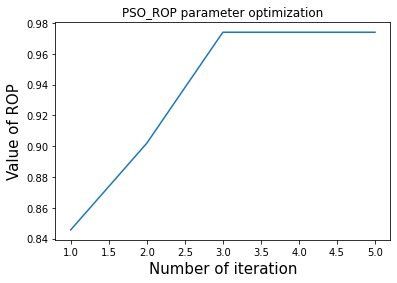

Final parameters are : [0, 0.01]
No. 1
Depth    0.003188
RPM      1.000000
WOB      0.003740
Name: 1, dtype: float64


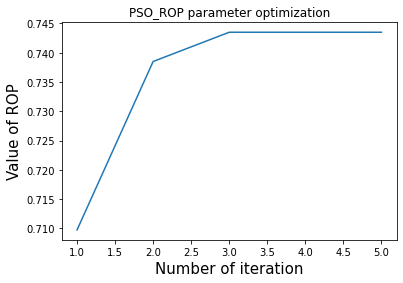

Final parameters are : [0.41470588235294126, 0.01]
No. 2
Depth    0.005665
RPM      1.000000
WOB      0.000000
Name: 2, dtype: float64


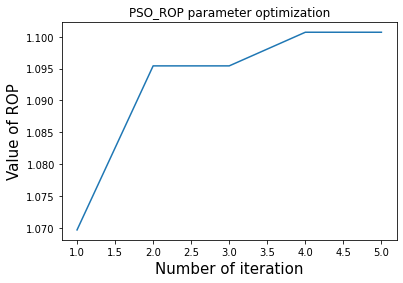

Final parameters are : [0.41470588235294126, 0.01]
No. 3
Depth    0.007877
RPM      1.000000
WOB      0.027025
Name: 3, dtype: float64


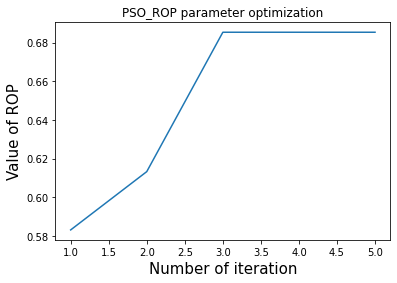

Final parameters are : [0, 0.01]
No. 4
Depth    0.010010
RPM      1.000000
WOB      0.013168
Name: 4, dtype: float64


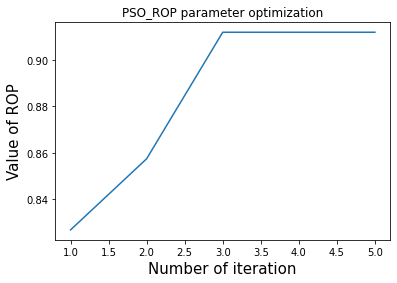

Final parameters are : [0, 0.01]
No. 5
Depth    0.332320
RPM      1.000000
WOB      0.376451
Name: 5, dtype: float64


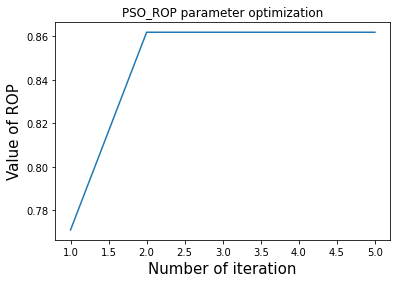

Final parameters are : [0, 0.01]
No. 6
Depth    0.335571
RPM      1.000000
WOB      0.276672
Name: 6, dtype: float64


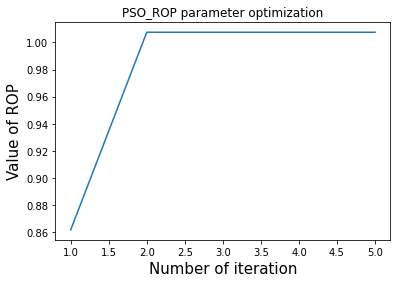

Final parameters are : [0, 0.01]
No. 7
Depth    0.338704
RPM      1.000000
WOB      0.331416
Name: 7, dtype: float64


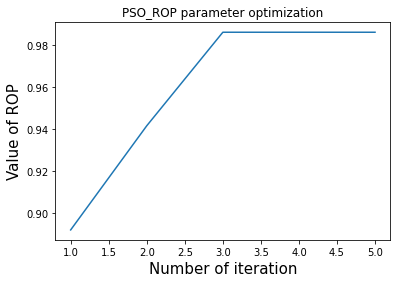

Final parameters are : [0, 0.01]
No. 8
Depth    0.342783
RPM      1.000000
WOB      0.397510
Name: 8, dtype: float64


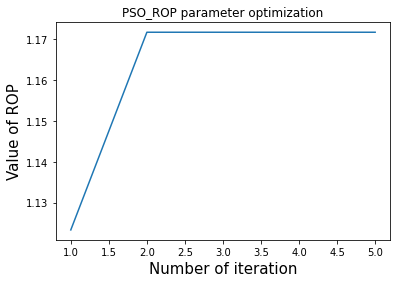

Final parameters are : [0, 0.01]
No. 9
Depth    0.345675
RPM      1.000000
WOB      0.397497
Name: 9, dtype: float64


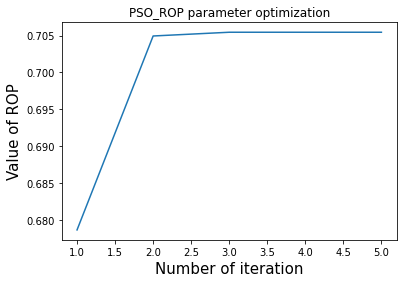

Final parameters are : [0, 0.525395978559218]
No. 10
Depth    0.370282
RPM      1.000000
WOB      0.406689
Name: 10, dtype: float64


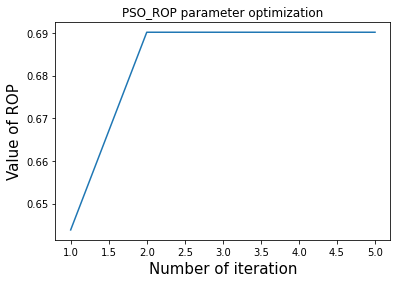

Final parameters are : [0.41470588235294126, 0.01]
No. 11
Depth    0.370829
RPM      1.000000
WOB      0.431218
Name: 11, dtype: float64


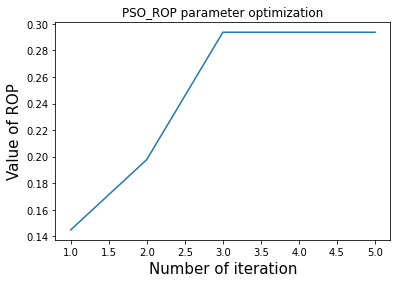

Final parameters are : [0, 0.01]
No. 12
Depth    0.371837
RPM      1.000000
WOB      0.394760
Name: 12, dtype: float64


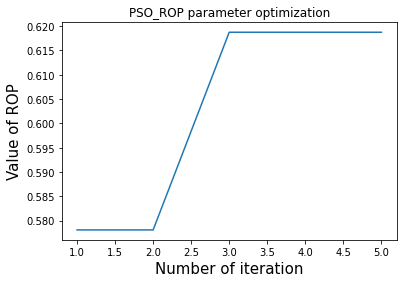

Final parameters are : [0, 0.1127169775659064]
No. 13
Depth    0.373666
RPM      1.000000
WOB      0.414994
Name: 13, dtype: float64


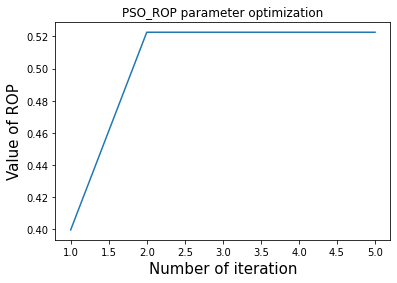

Final parameters are : [0, 0.01]
No. 14
Depth    0.374666
RPM      1.000000
WOB      0.357485
Name: 14, dtype: float64


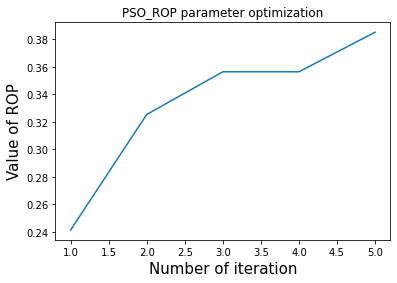

Final parameters are : [0, 0.01]
No. 15
Depth    0.829679
RPM      0.000000
WOB      0.694861
Name: 15, dtype: float64


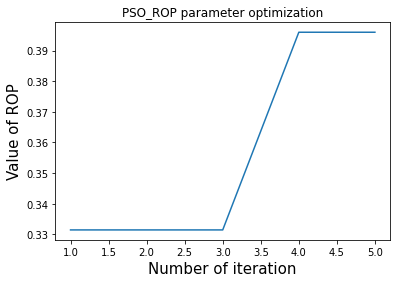

Final parameters are : [0.41470588235294126, 0.01]
No. 16
Depth    0.832383
RPM      0.000000
WOB      0.780314
Name: 16, dtype: float64


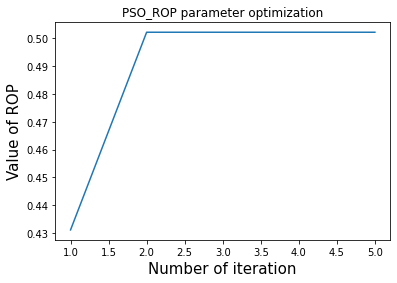

Final parameters are : [0.41470588235294126, 0.01]
No. 17
Depth    0.835649
RPM      0.414706
WOB      0.823819
Name: 17, dtype: float64


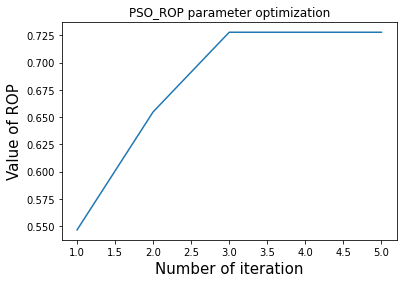

Final parameters are : [0, 0.01]
No. 18
Depth    0.839267
RPM      0.414706
WOB      0.796885
Name: 18, dtype: float64


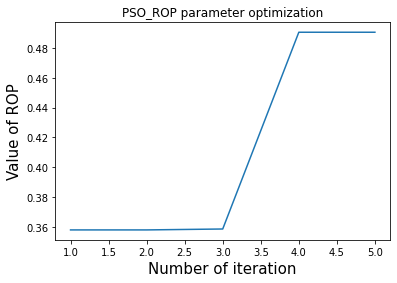

Final parameters are : [0, 0.01]
No. 19
Depth    0.840674
RPM      0.414706
WOB      0.594505
Name: 19, dtype: float64


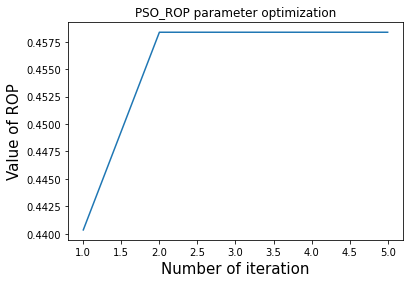

Final parameters are : [0, 0.01]
No. 20
Depth    0.856169
RPM      0.000000
WOB      0.850329
Name: 20, dtype: float64


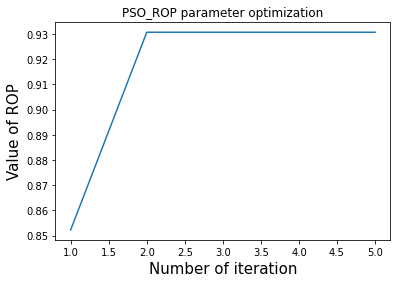

Final parameters are : [0, 0.01]
No. 21
Depth    0.860764
RPM      0.000000
WOB      0.856623
Name: 21, dtype: float64


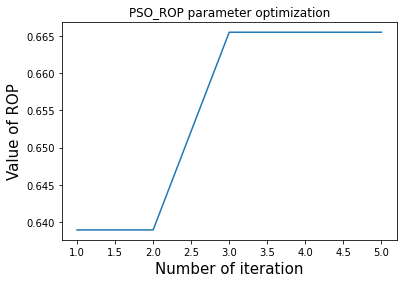

Final parameters are : [0.41470588235294126, 0.01]
No. 22
Depth    0.864867
RPM      0.000000
WOB      0.862507
Name: 22, dtype: float64


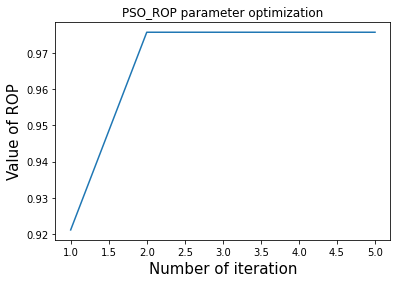

Final parameters are : [0, 0.01]
No. 23
Depth    0.869243
RPM      0.000000
WOB      0.890448
Name: 23, dtype: float64


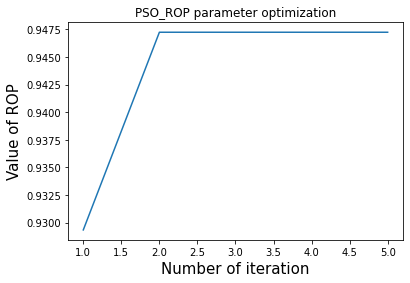

Final parameters are : [0, 0.2629596488212493]
No. 24
Depth    0.873314
RPM      0.000000
WOB      0.806390
Name: 24, dtype: float64


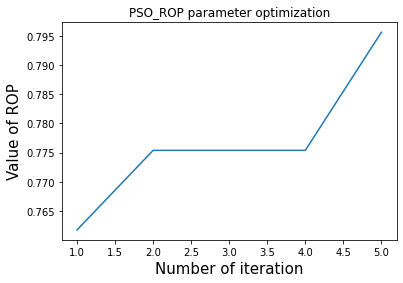

Final parameters are : [0, 0.2733250127272306]
No. 25
Depth    0.993522
RPM      0.000000
WOB      0.926790
Name: 25, dtype: float64


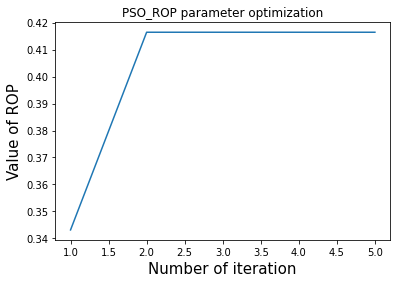

Final parameters are : [0.41470588235294126, 0.01]
No. 26
Depth    0.995897
RPM      0.000000
WOB      0.899278
Name: 26, dtype: float64


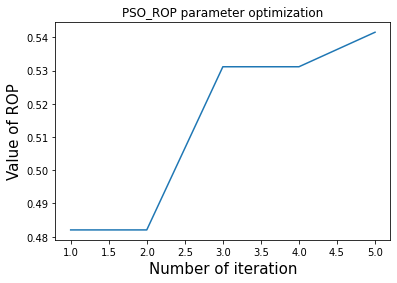

Final parameters are : [0.41470588235294126, 0.017177079381904433]
No. 27
Depth    0.997929
RPM      0.000000
WOB      0.954762
Name: 27, dtype: float64


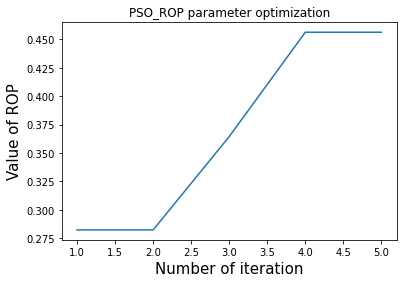

Final parameters are : [0, 0.01]
No. 28
Depth    0.999773
RPM      0.000000
WOB      1.000000
Name: 28, dtype: float64


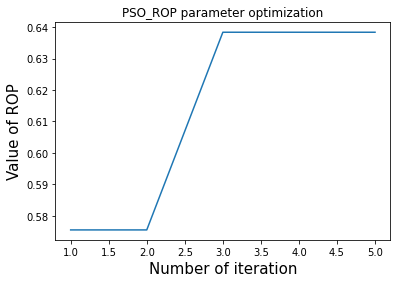

Final parameters are : [0, 0.01]
No. 29
Depth    1.000000
RPM      0.000000
WOB      0.989505
Name: 29, dtype: float64


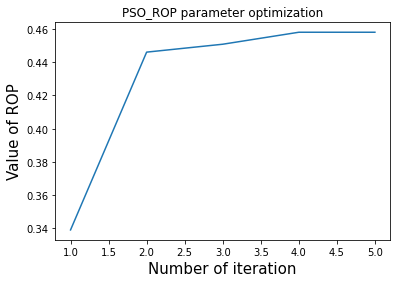

Final parameters are : [0, 0.16412522493488105]


In [16]:
model = Twoinput()
model.load_state_dict(torch.load('best_model_state_dict.pth'))
model.eval()
pso_parameter=[]
pso_rop=[]
# RPM=np.array(list(set(train_all_x['RPM'])))
RPM=np.array([343,484, 683])
RPM=ms.fit_transform(RPM.reshape(-1, 1))
RPM=RPM.reshape(3)
for j in range(len(train_all_x)):
# for j in range(1):
  train_x_pso_initial=train_all_x.loc[j]
  img_pso=imagepath.loc[j]
  train_y_pso_initial=train_all_y.loc[j]
  particle_num = 5
  # particle_num = 2
  particle_dim = 2#寻优参数个数
  iter_num = 5
  # iter_num = 5
  # c1 = 2
  # c2 = 2
  # w = 0.9
  c1 = 2
  c2 = 2
  w = 0.9
  max_value = 0.99
  min_value = 0.01
  print('No.',j)
  print(train_x_pso_initial)
  pso = PSO(particle_num,particle_dim,iter_num,c1,c2,w,max_value,min_value,train_x_pso_initial,img_pso,train_y_pso_initial,model)
  gbest_parameter,best_fitness=pso.main()
  pso_parameter.append(gbest_parameter)
  pso_rop.append(best_fitness.detach().numpy())

In [17]:
#对比优化前后数据
pso_parameter=np.array(pso_parameter)
RPM=pso_parameter[:,0]
WOB=pso_parameter[:,1]
# SPP=pso_parameter[:,1]
# train_initial=train_all[0:35]
RPM_minmax=MinMaxScaler().fit(train_all['RPM'].values.reshape(-1,1))
RPM_pso=RPM_minmax.inverse_transform(RPM.reshape(-1,1))
WOB_minmax=MinMaxScaler().fit(train_all['WOB'].values.reshape(-1,1))
WOB_pso=WOB_minmax.inverse_transform(WOB.reshape(-1,1))
y_minmax=MinMaxScaler().fit(train_all['ROP'].values.reshape(-1,1))
pso_rop=np.array(pso_rop)
y_pso=y_minmax.inverse_transform(pso_rop.reshape(1,-1))

In [18]:
index=[i for i in range(len(Roundtrip))]
train_pso=pd.DataFrame({'RPM_pso':RPM_pso[:,0],'WOB_pso':WOB_pso[:,0],'ROP_pso':y_pso[0]},index=index)

In [19]:
print((train_pso['ROP_pso'].mean()-train_all['ROP'].mean())/train_all['ROP'].mean())
print((train_pso['ROP_pso'].mean()-train_all['ROP'].mean()))

0.1915420805851405
0.36077910649606926


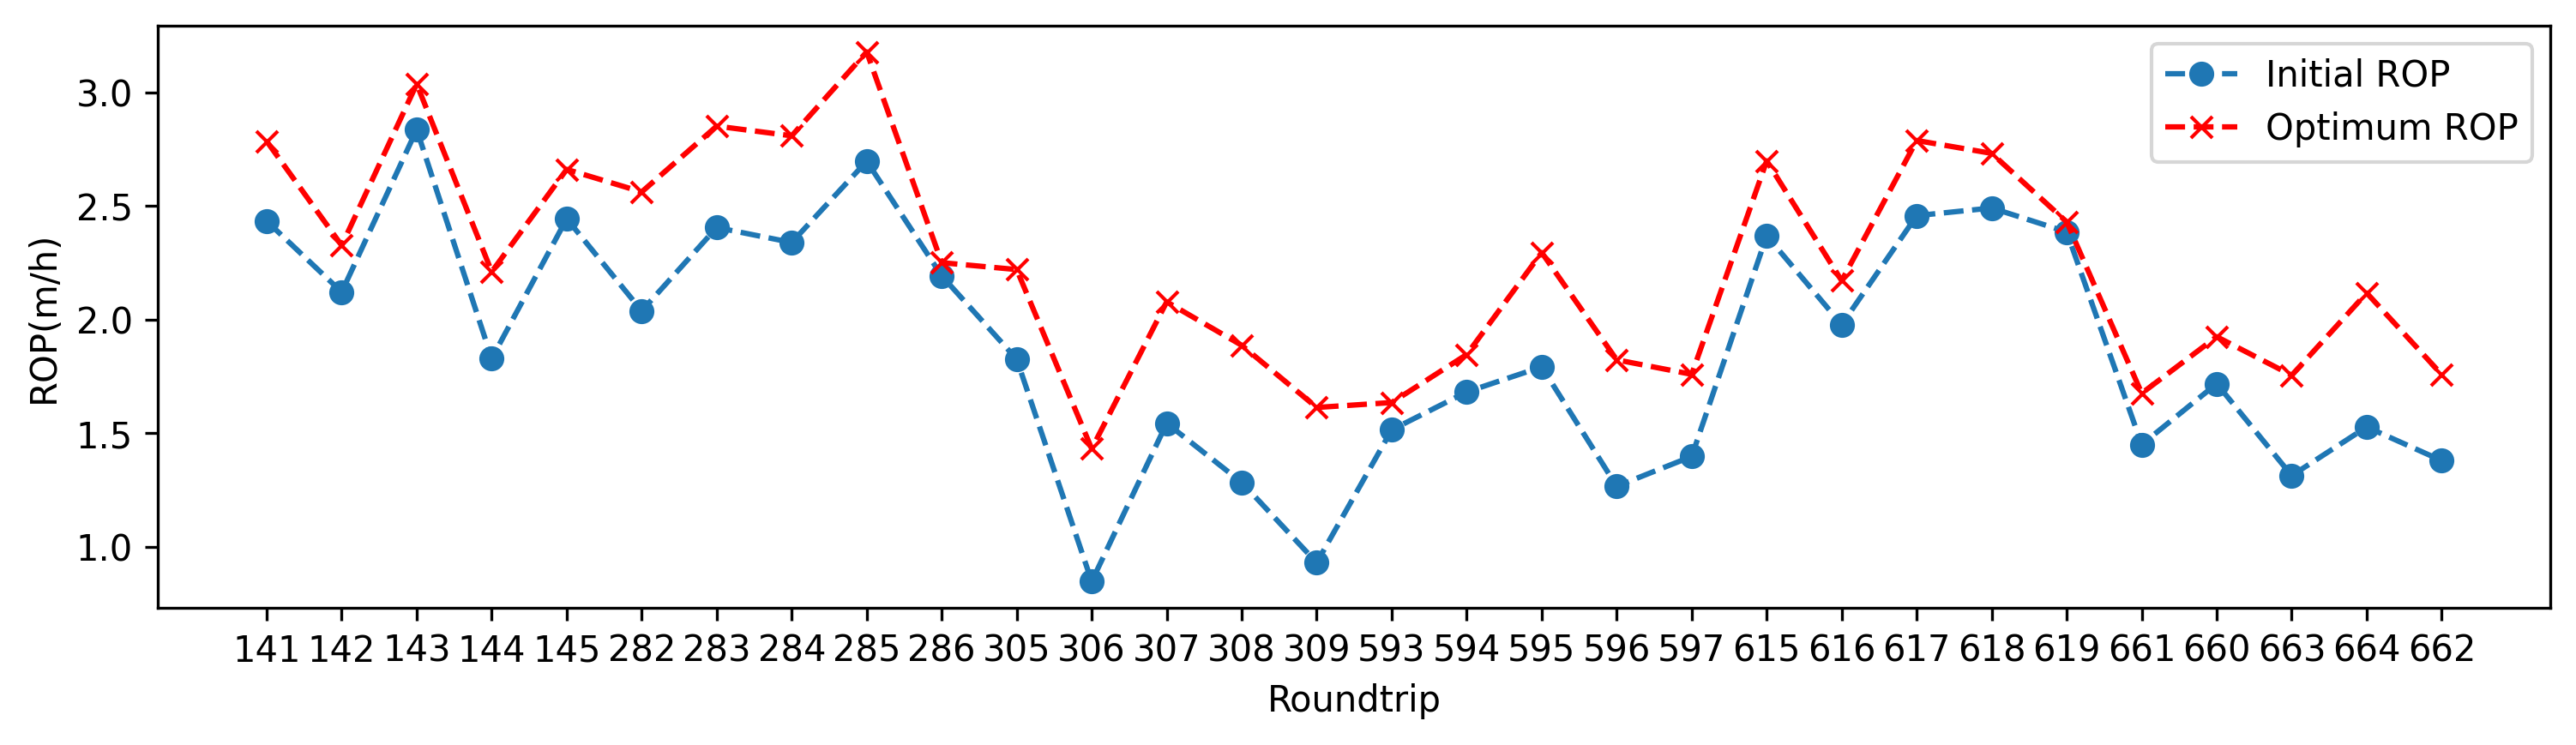

In [20]:
#对比优化前后数据
from matplotlib.pyplot import MultipleLocator
fig1=plt.figure(figsize=(12,3),dpi=300)
# plt.plot(train_initial['Roundtrip'],train_initial['ROP'],label='Denoised ROP',linestyle='--',marker = "o")
# plt.plot(train_initial['Roundtrip'],train_pso['ROP_pso'],color='r',label='Optimum ROP',linestyle='--',marker = "x")
plt.plot(train_all['ROP'],label='Initial ROP',linestyle='--',marker = "o")
plt.plot(train_pso['ROP_pso'],color='r',label='Optimum ROP',linestyle='--',marker = "x")
# plt.ylim(-100,2400)
# y_major_locator=MultipleLocator(1)
# ax = plt.gca()  
# ax.invert_yaxis()
plt.ylabel('ROP(m/h)')
plt.xlabel('Roundtrip')
plt.xticks([i for i in range(len(Roundtrip))],Roundtrip)
plt.legend(loc='upper right')
plt.savefig('rop_pso.png', dpi=300,bbox_inches='tight')

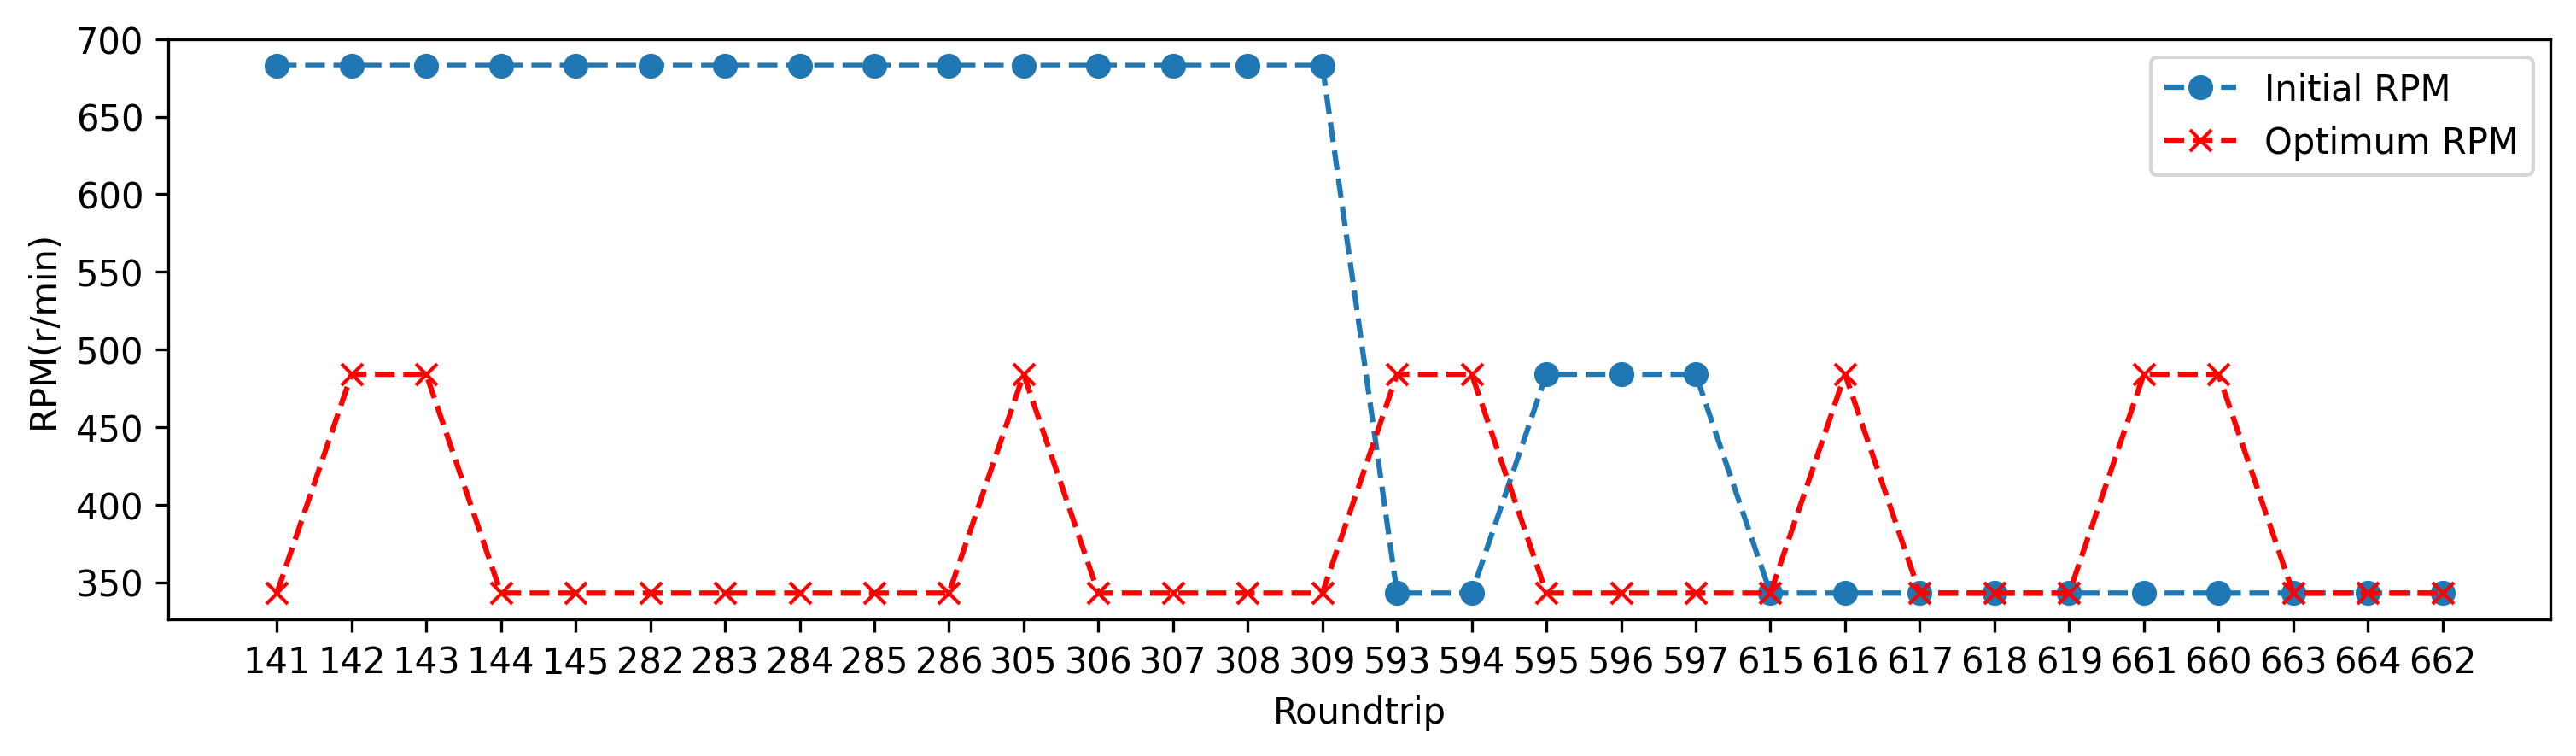

In [21]:
#对比优化前后数据
fig1=plt.figure(figsize=(12,3),dpi=300)
plt.plot(train_all['RPM'],label='Initial RPM',linestyle='--',marker = "o")
plt.plot(train_pso['RPM_pso'],color='r',label='Optimum RPM',linestyle='--',marker = "x")
plt.ylabel('RPM(r/min)')
plt.xlabel('Roundtrip')
plt.xticks([i for i in range(len(Roundtrip))],Roundtrip)
plt.legend(loc='upper right')
plt.savefig('RPM_pso.png', dpi=300,bbox_inches='tight')

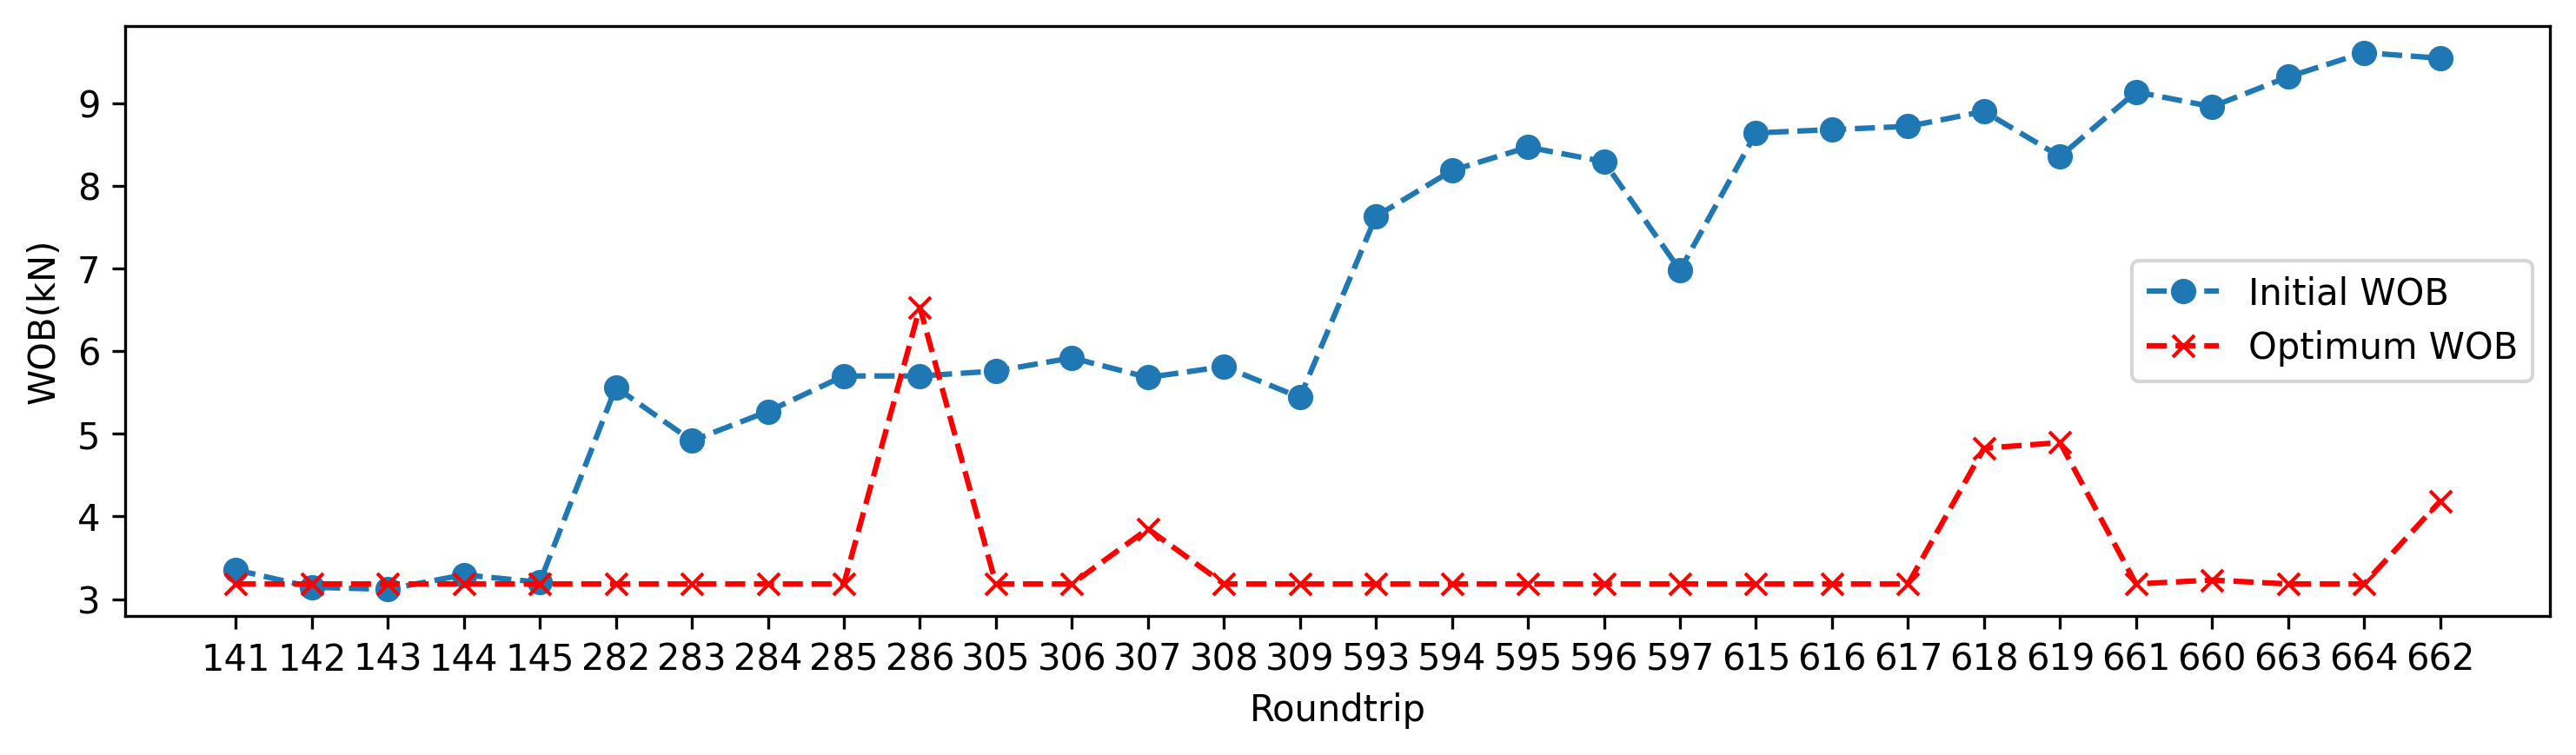

In [22]:
#对比优化前后数据
fig1=plt.figure(figsize=(12,3),dpi=300)
plt.plot(train_all['WOB'],label='Initial WOB',linestyle='--',marker = "o")
plt.plot(train_pso['WOB_pso'],color='r',label='Optimum WOB',linestyle='--',marker = "x")
plt.ylabel('WOB(kN)')
plt.xlabel('Roundtrip')
plt.xticks([i for i in range(len(Roundtrip))],Roundtrip)
plt.legend(loc='right')
plt.savefig('WOB_pso.png', dpi=300,bbox_inches='tight')